<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S21_sorter_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gtsam

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

from gtbook.discrete import Variables
from gtbook.display import show, pretty


# Modeling the World State

> :For this chapter, the physical properties of a piece of trash comprise all of the information needed by the robot.

For our simple trash sorting robot, the only thing that matters at a given moment is the category
of the item of trash on the conveyor belt (remember that items of trash are fed individually to the robot,
so there is no clutter, and no circumstance in which multiple pieces of trash are simultaneously in the workspace).
Therefore, it is natural to define the world state explicitly in terms of the category of the current
item of trash.

We will consider five possible categories:
- cardboard
- paper
- cans
- scrap metal
- bottle

Perhaps unrealistically, we assume here that there will never be a piece of trash that does not belong to any of these categories.  We will not, however, assume that the category of an item can be reliably determined with 100% accuracy. 
Instead, we will use probability theory to quantify the uncertainty associated to an object's categorization.

## Using Probability to Model Uncertainty

> :Probability theory provides a consistent, rigorous methodology for reasoning quantitatively about uncertainty.

While a comprehensive coverage of probability theory is beyond the scope of this book,
we will introduce key concepts and methods throughout the text, as needed,
to deal with various kinds of uncertainty that occur in robotics applications.
Rigorous introductions can be found in many textbooks, including [Probability for Data Science](https://probability4datascience.com/index.html) (which is available online).

The starting point for reasoning with uncertainty is to define the set of **outcomes** that might occur.
This set of all possible outocomes is called the **sample space**, often denoted by $\Omega.$
In our example, when an item of trash arrives on the conveyor belt,
there are five possible outcomes,

$\Omega = \{ \rm{cardboard, paper, cans, scrap \; metal, bottle}\}.$

## Probability Distribution
Subsets of $\Omega$ are called **events**.  A **probability distribution**, $P$, assigns a probability $0 \leq P(A) \leq 1$ to each event $A \subset \Omega$, with $P(\emptyset) = 0$ and $P(\Omega)=1$. 
In addition, for disjoint events, $A_i \cap A_j = \emptyset$, we have
$P(A_i \cup A_j) = P(A_i) + P(A_j)$.
Using this property, it is a simple matter to compute the probability for any $A \subset \Omega$
if we are provided with the probabilities of the individual outcomes.
Further, since $P(\Omega)=1$, it follows immediately that 
$$P(\Omega) = \sum_{\omega \in \Omega} P(\{\omega\}) = 1$$
i.e., that the probabilities of the individual outcomes sum to unity.
As a slight abuse of notation, for singleton events, we will often write $P(\omega)$ rather than $P(\{\omega\})$
to simplify notation.

In robotics applications, the probability assigned to an outcome reflects our certainty in that outcome.
These probabilities can change based on the arrival of new evidence.
In robotics, this can occur when the robot acts in the world, or based on sensor data.
How evidence affects the propagation of probability values will be a recurring topic in this book.

## Prior Probability Distributions
> :We can estimate a probability distribution from data that tells us how likely a particular outcome is, a priori.

Once we have enumerated the set of possible outcomes, we confront a fundamental question: *Where do the
probability values come from?*

In some cases, we merely assume that all outcomes are equally likely, for example, when rolling a die or tossing coin.
In such cases, the probability of any outcome is merely $P(\omega) = 1/N$ for each $\omega \in \Omega$, where $N =| \Omega |$.
This leads to $P(\mathrm{heads}) = P(\mathrm{tails}) = 0.5$ when tossing a fair coin, 
where $\Omega = \{ \mathrm{heads, tails} \}$.

In other cases, we can estimate probabilities using data.
Suppose, for example, that the owner of the trash-sorting facility has told us (or we kept statistics over time) that for every 1000 pieces of trash, the observed category counts are approximately as follows:
- cardboard: 200
- paper: 300
- cans: 250
- scrap metal: 200
- bottle: 50

It is common to assume that outcomes occur in proportion to their probability (there are a number of
technical conditions that underlie this assumption, such as the condition that outcomes are indpendent,
but we will not address these here). Thus, from the above observed frequencies, we might estimate that the probability of seeing a piece of cardboard in the work cell is given by

$$P(\mathrm{cardboard}) \approx 200/1000 = 0.2$$

Using the same logic, we can do the same for all categories, yielding:

| *Category (C)* | *P(C)* |
|----------------|:------:|
| cardboard      |   0.20 |
| paper          |   0.30 |
| can            |   0.25 |
| scrap metal    |   0.20 |
| bottle         |   0.05 |

We call this type of probabilistic knowledge about the state of the world, in the absence of any other information, a **prior**, because it represents our belief *before* any evidence (e.g., sensor data) has been acquired.
In this case the state of the world is merely the category of the piece of trash in our cell.

<!-- Here, a word about notation is in order.  We use upper case letters to denote random quantities. For example, we use $C$ to denote the random outcome of a particular
category of trash arriving to the sorting station.  When you see an uppercase letter, it indicates that we do not know what value this outcome will take, but
that we do know a probability distribution for the values that could occur.
We use lower case letters, possibly subscripted, to denote specific outcomes. For example, we might define $c_1 =$ cardboard,
$c_2 =$ paper, etc.  Thus, we might write $P(C = c_1)$ or merely $P(c_1)$ to denote the prior probability that an item of trash is cardboard. -->

## Probability Distributions in Python
> :In this book, we represent probability distributions using the GTSAM library, which defines a `DiscretePrior` class to do just that.

The code below illustrates the use of GTSAM. Although not strictly necessary, we can create a `Variables` data structure to provide more informative output:

In [3]:
variables = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = variables.discrete("Category", categories)

We can now create a prior probability $P(Category)$ on the category: 

In [4]:
category_prior = gtsam.DiscretePrior(Category, "200/300/250/200/50")

The constructor automatically normalizes to a proper probability distribution, i.e., it sums to one. It is rendered in notebook as a table below, where we can verify this:

In [5]:
category_prior

 *P(0)*:

|0|value|
|:-:|:-:|
|0|0.2|
|1|0.3|
|2|0.25|
|3|0.2|
|4|0.05|


As you can see, GTSAM does not actually store the category names, but represents them using a base 0 integer index from 0...4.

It is annoying that we only see integers. Luckily, because we created the `variables` structure, we can pretty-print using the `pretty` method:

In [6]:
pretty(category_prior, variables)

 *P(Category)*:

|Category|value|
|:-:|:-:|
|cardboard|0.2|
|paper|0.3|
|can|0.25|
|scrap metal|0.2|
|bottle|0.05|


## Common Operations

We can of course evaluate the prior for any category value:

In [7]:
index = categories.index('can')  # we still have to use an integer value
Pcan = category_prior(index)
print(f"P('can') = {Pcan}")

P('can') = 0.25


We can also recover all values in the probability mass function at once, like so:

In [8]:
PMF = category_prior.pmf()
PMF

[0.2, 0.3, 0.25, 0.2, 0.05]

Note that the ordering of the array was fixed when we defined `categories` above.  It is your responsibility
to maintain consistency when using arrays to store values associated to a collection of variables.

We can display probability distributions in various ways, including as a bar graph, as shown below.

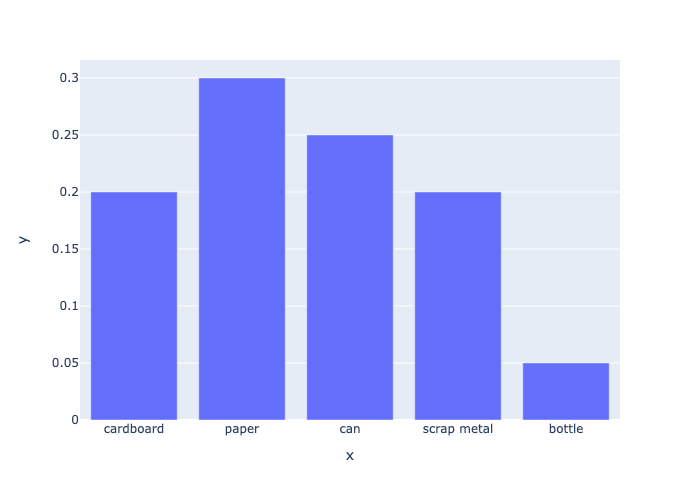

In [9]:
px.bar(y=PMF, x=categories)

## Simulation by Sampling

> :Sampling from the prior simulates our trash sorting cell.

### Intro
Suppose we wish to simulate our trash sorting system such that the behavior of the simulation matches, 
in some statistical sense, the behavior of the actual system.
In our case, this amounts to generating samples from the probability distribution
on trash categories.
In particular, we would like to generate a sequence of categories,
$\omega_1, \omega_2, \dots, \omega_n$ such that 
$\omega_i = \mathrm{cardboard}$ approximately 25% of the time,
$\omega_i = \mathrm{paper}$ approximately 20% of the time, etc.
How can we write a computer program to do this?

While most programming libraries do not include functions to generate samples from an arbitrary distribution,
almost all include a random number generator that will generate a random number from the unit interval.
We denote by $U(a,b)$ the uniform probability distribution on the interval $[a,b]$.
In numpy, the function *np.random.rand()* generates a sample $x \sim U(0,1)$.
How can we use this result to generate a sample from an aribitrary probability distribution?

### Cumulative Distribution Function
We begin by introducing the Cumulative Distribution Function (CDF).
For a random variabls $X$, the CDF for $X$ is defined as
as 

$$F_X(\alpha) = P(X \leq \alpha)$$

It follows immediately that $0 \leq F_X(\alpha) \leq 1$,
since $F_X(\alpha)$ is itself a probability.
In the case of discrete random variables,
say $X \in \{ x_0, \dots x_n\}$, we can compute the CDF
$F_X(\alpha)$ by summing the probabilities assigned
to all $x_i \leq \alpha$

$$F(\alpha) = \sum_{x_i \leq \alpha} P(x_i) = \sum_{i=0}^{k-1} P(x_i)$$

in which the rightmost summation follows if we choose $k$ such that $x_{k-1} < \alpha \leq x_k$.
The terminology *Cumulative Distribution Function* is due to the fact that $F(\alpha)$
is the accumulated probability assigned to all outcomes less than or equal to $\alpha$,
which is apparent in these sumuation expressions.

But what does this have to do with generating samples from our distribution on categories?
The idea is simple: we can generate $x\sim U(0,1)$, and a CDF takes on values in the
interval $[0,1]$.  For a discrete random variable $X \in \{ x_0, \dots x_n\}$
the probability that our sample $x$ corresponds to category $k$
is exactly equal to $F_X(x_k) - F_X(x_{k-1})$.

To see this, we impose an ordering on our categories,
- $c_0 = \mathrm{cardboard}$
- $c_1 = \mathrm{paper}$
- $c_2 = \mathrm{can}$
- $c_3 = \mathrm{scrap \; metal}$
- $c_4 = \mathrm{bottle}$

and we define the random variable $X \in \{ 0,1,2,3,4\}$ to be the index of the chosen category.
The CDF for $X$ is given by:

| $x_i$ | $F_X$($x_i$) |
|----------------|:------:|
| cardboard    |   0.20 |
| paper    |   0.50 |
| can    |   0.75 |
| scrap metal    |   0.95 |
| bottle    |   1.00 |

### Example
Some numpy code to generate the CDF:

In [10]:
CDF = np.cumsum(PMF)
print(CDF)

[0.2  0.5  0.75 0.95 1.  ]



Now, suppose we generate a random sample $x \sim U(0,1)$,
and use this $x$ to choose category $k$ such that $F_X(x_{k-1}) < x \leq F_X(x_k)$.
For example, we choose category 4 if $0.95 < x \leq 1.0$.
In this case, what is the probability of choosing category 4?
The answer follows from the fact that,
for the uniform distribution, $P(X \in [a,b]) = b-a$.
Therefore, the probability that our sample lies in the interval $[0.95,1.0]$ is
$0.05$, which happens to be exactly the prior probability assigned to category 4!
Likewise, if our sample $x$ satisfies $0.2 < x \leq 0.5$,
we choose category 1, and the probability that our sample lies in the interval
$[0.2,0.5]$ is $0.3$, which is, as expected, exactly the prior probability assigned
to category 1


The code to accomplish sampling is:

In [11]:
def sample():
    u = np.random.rand()
    for category in range(5):
        if u<float(CDF[category]):
            return category

Plotting this as a histogram:

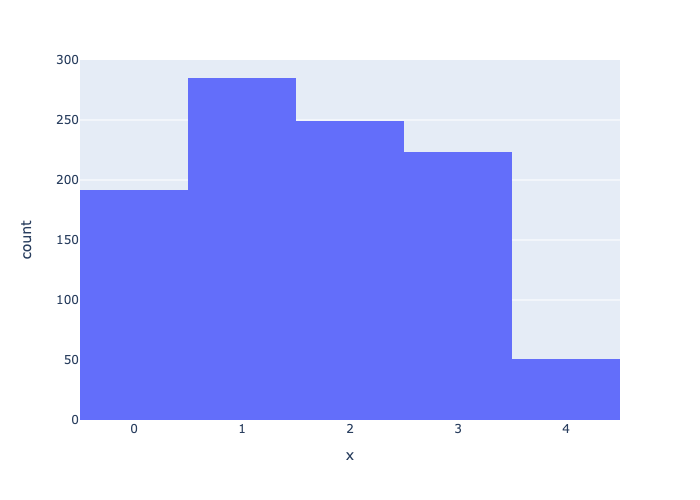

In [12]:
px.histogram(x=[sample() for i in range(1000)])

### In GTSAM
Of course, GTSAM has all this machinery built-in:

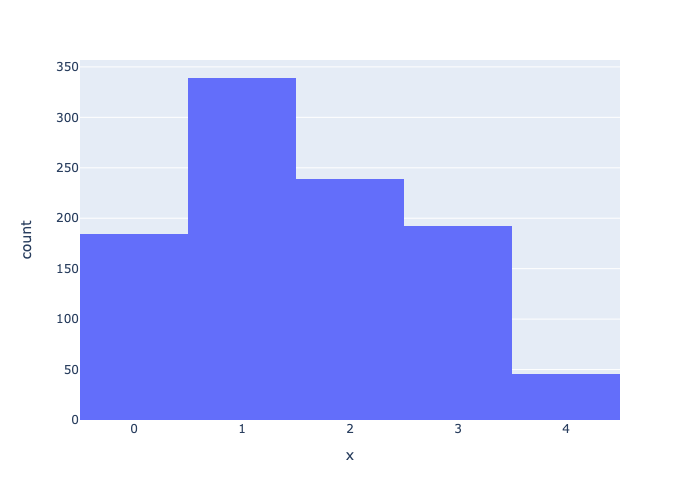

In [13]:
px.histogram(x=[category_prior.sample() for i in range(1000)])

## GTSAM Internals

GTSAM does not actually store the category names, but represents them using a base 0 integer index from 0...4.

Internally, a discrete prior is actually represented as a small decision tree, which allows us to save some memory for probability tables with many zeros. We can use the `show` function to visualize it:

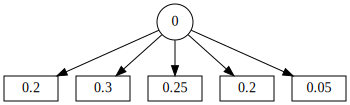

In [14]:
show(category_prior)

The arrows above represent each of the possible categories and point to the prior probability of that category. Unfortunately, while we can render the decision tree graphically, this internal GTSAM data structure has no ability to pretty-print the variables/values: everything is an int. The arrows *are* rendered from left to right, so we can see that `categories[3]`, "scrap metal", has a probability of 20%.